In [2]:
# Janky xgboost fix
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
import pandas as pd
import numpy as np
import re
import os.path
import xgboost as xgb
import imblearn.over_sampling
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

### Load Data

In [4]:
order_path = '../data/subset/'
common_path = '../data/common/'

In [5]:
orders_df = pd.read_csv(os.path.join(order_path, 'orders.csv'))
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1363380,50,prior,1,3,9,NaN
1,3131103,50,prior,2,6,12,10.0
2,2197066,50,prior,3,1,13,9.0
3,3201640,50,prior,4,0,11,6.0
4,2756806,50,prior,5,4,14,11.0


In [6]:
orders_prior_df = pd.read_csv(os.path.join(order_path, 'order_products__prior.csv'))
orders_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,12,30597,1,1
1,12,15221,2,1
2,12,43772,3,1
3,12,37886,4,1
4,12,37215,5,0


In [7]:
orders_train_df = pd.read_csv(os.path.join(order_path, 'order_products__train.csv'))
orders_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1077,13176,1,1
1,1077,39922,2,1
2,1077,5258,3,1
3,1077,21137,4,1
4,1119,6046,1,1


In [8]:
depts_df = pd.read_csv(os.path.join(common_path, 'departments.csv'))
depts_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [9]:
aisles_df = pd.read_csv(os.path.join(common_path, 'aisles.csv'))
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [10]:
products_df = pd.read_csv(os.path.join(common_path, 'products.csv'))
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


### Merge Product Dataframes

In [11]:
products_df = products_df.merge(aisles_df, how='left', on='aisle_id')
products_df = products_df.merge(depts_df, how='left', on='department_id')
products_df.drop(['aisle_id', 'department_id'], axis=1, inplace=True)
products_df.head()

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,2,All-Seasons Salt,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen meals,frozen
4,5,Green Chile Anytime Sauce,marinades meat preparation,pantry


In [12]:
orders_prior_df = orders_prior_df.merge(orders_df.drop('eval_set', axis=1), on='order_id')
orders_train_df = orders_train_df.merge(orders_df.drop('eval_set', axis=1), on='order_id')
orders_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,12,30597,1,1,152610,22,6,8,10.0
1,12,15221,2,1,152610,22,6,8,10.0
2,12,43772,3,1,152610,22,6,8,10.0
3,12,37886,4,1,152610,22,6,8,10.0
4,12,37215,5,0,152610,22,6,8,10.0


### Merge Cart-level DataFrame

In [113]:
user_product_prior_df = (orders_prior_df.groupby(['product_id', 'user_id'], as_index=False)
                                        .agg({'order_id':'nunique',
                                              'add_to_cart_order':'mean',
                                              'order_dow':'mean',
                                              'order_hour_of_day':'mean'})
                                        .rename(columns={'order_id':'count_in_user_orders',
                                                         'add_to_cart_order':'prior_cart_add_order',
                                                         'order_dow':'prior_order_dow',
                                                         'order_hour_of_day':'prior_order_hour'}))

train_users = orders_train_df['user_id'].unique()
user_product_df = user_product_prior_df[user_product_prior_df['user_id'].isin(train_users)]
user_product_df.reset_index(drop=True, inplace=True)

orders_prior_per_user_df = orders_prior_df.groupby(['user_id'])[['order_id']].nunique()
orders_prior_per_user_df.rename(columns={'order_id':'total_user_orders'}, inplace=True)
user_product_df = user_product_prior_df.merge(orders_prior_per_user_df, on='user_id')
user_product_df['percent_in_user_orders'] = (user_product_df['count_in_user_orders'] /
                                             user_product_df['total_user_orders'])
#user_product_df.head()

In [114]:
train_carts = (orders_train_df.groupby('user_id')
                              .agg({'product_id':(lambda x: set(x)),
                                    'order_dow':'first',
                                    'order_hour_of_day':'first'})
                              .rename(columns={'product_id':'cart_contents',
                                               'order_hour_of_day':'order_hour'}))

user_product_df = user_product_df.merge(train_carts, on='user_id')
user_product_df['in_cart'] =\
    (user_product_df.apply(lambda row: row['product_id'] in row['cart_contents'], axis=1)
                    .astype(int))

#user_product_df.head()

### Feature Engineering

#### Feature: Product Overall Order Rate

In [115]:
product_prior_df = (orders_prior_df.groupby(['product_id'], as_index=False)
                                   .agg({'order_id':'nunique'})
                                   .rename(columns={'order_id':'count_in_all_orders'})
                                   .sort_values(by=['count_in_all_orders'], ascending=False)
                                   .reset_index(drop=True))
num_orders = orders_prior_df['order_id'].nunique()
product_prior_df['percent_in_all_orders'] = product_prior_df['count_in_all_orders'] / num_orders
#product_prior_df.head(10)
user_product_df = user_product_df.merge(product_prior_df, on='product_id')

#### Feature: Absolute Difference in Order Time

In [116]:
user_product_df['order_dow_diff'] = np.abs(user_product_df['prior_order_dow'] -
                                           user_product_df['order_dow'])
user_product_df['order_hour_diff'] = np.abs(user_product_df['prior_order_hour'] -
                                           user_product_df['order_hour'])

#### Feature: In Last Cart

In [117]:
mask = (orders_prior_df.sort_values(by='order_number')
                       .groupby(['user_id'])['order_id']
                       .last())
last_cart_contents_df = (orders_prior_df[orders_prior_df['order_id'].isin(mask)]
                    .groupby(['user_id'])['product_id'].unique())
last_cart_contents_df = pd.DataFrame(last_cart_contents_df)
last_cart_contents_df.rename(columns={'product_id':'last_cart_contents'}, inplace=True)

user_product_df = user_product_df.merge(last_cart_contents_df, how='left', on='user_id')
user_product_df['in_last_cart'] =\
    (user_product_df.apply(lambda row: row['product_id'] in row['last_cart_contents'], axis=1)
                    .astype(int))

### Feature: Days/Orders Since Last Order

In [229]:
prior_order_nums_df = (orders_prior_df.groupby(['user_id', 'order_id'], as_index=False)
                                      .agg({'order_number':'first',
                                            'days_since_prior_order':'first'}))
prior_order_nums_df = (prior_order_nums_df.drop('days_since_prior_order', axis=1)
                                          .merge(prior_order_nums_df.drop('order_id', axis=1),
                                                                          how='left',
                                                                          on='user_id'))

mask = prior_order_nums_df['order_number_x'] >= prior_order_nums_df['order_number_y']
prior_order_nums_df = prior_order_nums_df[mask].drop(['user_id', 'order_number_y'], axis=1)
prior_order_nums_df = (prior_order_nums_df.groupby(['order_id', 'order_number_x'],
                                                   as_index=False)['days_since_prior_order']
                                                   .sum())
prior_order_nums_df.rename(columns={'days_since_prior_order':'days_since_first_order',
                                    'order_number_x':'order_number'}, inplace=True)

In [240]:
product_prior_since_df = orders_prior_df[['user_id', 'order_id', 'product_id']]
product_prior_since_df = product_prior_since_df.merge(prior_order_nums_df,
                                                      how='left',
                                                      on='order_id')

product_prior_since_df.sort_values(by=['user_id', 'product_id', 'order_number'], inplace=True)
product_prior_since_df['last_order_number'] =\
    product_prior_since_df.groupby(['user_id', 'product_id'])['order_number'].shift(1)
product_prior_since_df['last_days_since_first_order'] =\
    product_prior_since_df.groupby(['user_id', 'product_id'])['days_since_first_order'].shift(1)
product_prior_since_df['orders_since_last'] = (product_prior_since_df['order_number'] -
                                               product_prior_since_df['last_order_number'])
product_prior_since_df['days_since_last'] = (product_prior_since_df['days_since_first_order'] -
                                             product_prior_since_df['last_days_since_first_order'])

product_prior_since_df = (product_prior_since_df.groupby(['user_id', 'product_id'], as_index=False)
                                                .agg({'orders_since_last':'mean',
                                                      'days_since_last':'mean'}))

In [241]:
product_prior_since_df.head(50)

,user_id,product_id,orders_since_last,days_since_last
0,50,1202,NaN,NaN
1,50,2132,NaN,NaN
2,50,2643,NaN,NaN
3,50,4601,NaN,NaN
4,50,4656,NaN,NaN
5,50,5240,NaN,NaN
6,50,5612,1.666667,9.242424
7,50,5785,NaN,NaN
8,50,5876,9.500000,39.500000
9,50,5922,14.000000,66.500000


#### Check All Features

In [118]:
user_product_df.head()

,product_id,user_id,count_in_user_orders,prior_cart_add_order,prior_order_dow,prior_order_hour,total_user_orders,percent_in_user_orders,cart_contents,order_dow,order_hour,in_cart,count_in_all_orders,percent_in_all_orders,order_dow_diff,order_hour_diff,last_cart_contents,in_last_cart
0,1,21285,1,3.0,0.00,15.00,48,0.020833,"{21573, 35561, 37710, 11759, 12341, 13176, 32478}",4,10,0,26,0.000335,4.00,5.00,"[13176, 12341, 35561, 32478, 39581, 25133]",0
1,1,47549,4,4.0,4.25,18.25,26,0.153846,"{27845, 27790, 13042, 10326, 37687}",0,23,0,26,0.000335,4.25,4.75,[27845],0
2,1,54136,1,3.0,2.00,13.00,23,0.043478,"{47977, 5450, 26604, 5296, 11123, 24852, 10070...",1,11,0,26,0.000335,1.00,2.00,"[47977, 9623, 31486, 26767]",0
3,1,54240,1,2.0,2.00,16.00,5,0.200000,"{12427, 26348}",0,7,0,26,0.000335,2.00,9.00,[26348],0
4,1,95730,1,1.0,1.00,14.00,9,0.111111,"{39657, 10441, 12427, 37710, 10258, 32921, 45051}",2,10,0,26,0.000335,1.00,4.00,[27714],0


### Split Into Train, Validate, and Test Sets

In [31]:
def train_val_test_by_user(df, x_cols, y_col, val_size=.2, test_size=.1, seed=29):
    rndm = np.random.RandomState(seed)
    all_users = df['user_id'].unique()
    
    # Splits off holdout test set
    non_test_users = rndm.choice(all_users,
                                 size=int(all_users.size * (1-test_size)),
                                 replace=False)
    test_df = df[~df['user_id'].isin(non_test_users)]
    
    # Splits off train and validation sets
    val_users = rndm.choice(non_test_users,
                            size=int(all_users.size * val_size),
                            replace=False)
    val_df = df[df['user_id'].isin(val_users)]
    train_df = df[~df['user_id'].isin(val_users)]
    
    return (train_df[x_cols], train_df[y_col],
            val_df[x_cols], val_df[y_col],
            test_df[x_cols], test_df[y_col])

In [120]:
x_cols = ['percent_in_user_orders',
          'percent_in_all_orders',
          'total_user_orders',
          'in_last_cart']
y_col = 'in_cart'

X_train, y_train, X_val, y_val, X_test, y_test =\
    train_val_test_by_user(user_product_df, x_cols, y_col)

In [76]:
y_train.size, y_val.size, y_test.size

(265601, 64205, 34097)

### EDA

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


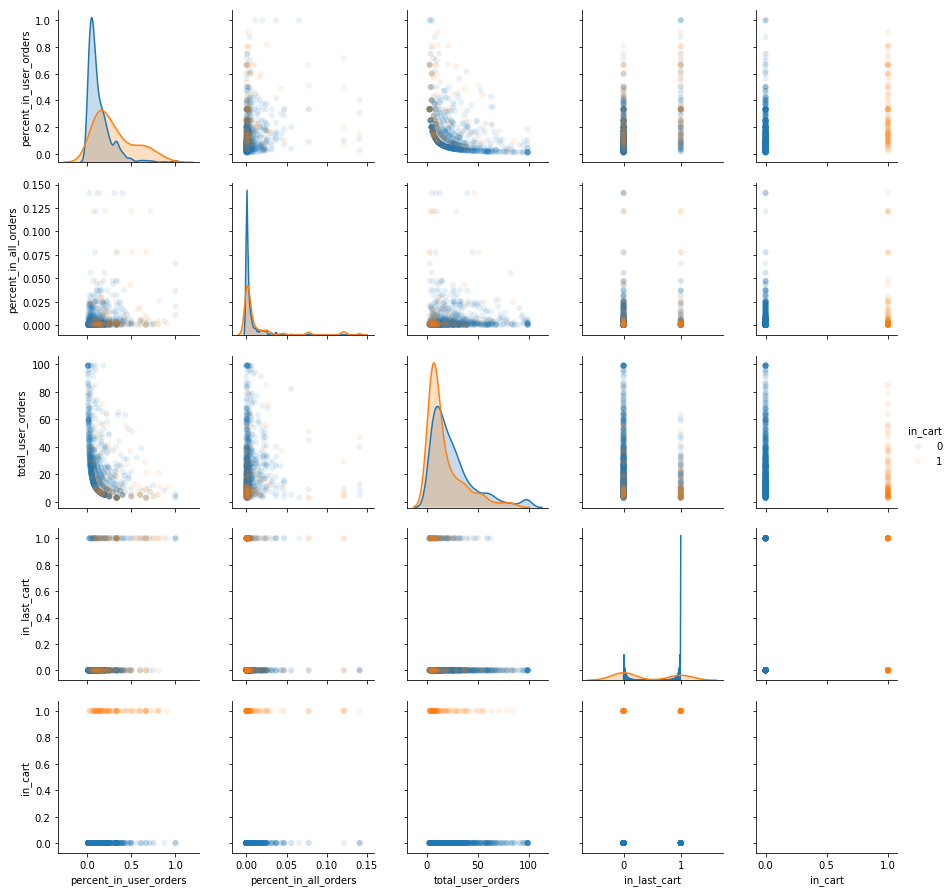

In [121]:
eda_df = pd.concat([X_train, y_train], axis=1).sample(1000)
sns.pairplot(eda_df, hue='in_cart', plot_kws=dict(alpha=.1, edgecolor='none'));

### Oversampling (Inactive)
Only significantly improved Logistic Regression
* Logistic = .23 to .35
* KNN = .24 to .29
* Random Forest = .24 to .27
* xgboost = .29 to .32

n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_neg, 0 : n_neg} 

ROS = imblearn.over_sampling.RandomOverSampler(ratio=ratio, random_state=29)    
X_train, y_train = ROS.fit_sample(X_train, y_train)

### Generic Threshold Adjustment Function

In [36]:
def adjust_threshold(model, X, threshold=.5):
    return (model.predict_proba(X)[:, 1] >= threshold).astype(int)

### Baseline Logistic Regression

In [37]:
def optimize_logistic_c(X_train, y_train, X_val, y_val):
    max_c = max_score = max_model = 0
    for c in range(-3, 6):
        c_val = 10 ** c
        model = LogisticRegression(C=c_val, solver='lbfgs', multi_class='auto')
        model.fit(X_train, y_train)
        score = f1_score(y_val, model.predict(X_val))
        if score > max_score:
            max_c = c_val
            max_score = score
            max_model = model
            
    print(f'C = {max_c} yields the highest score: {max_score}')
    return max_model

In [122]:
lr = optimize_logistic_c(X_train, y_train, X_val, y_val)

C = 10 yields the highest score: 0.25447173861197236


In [123]:
y_pred = lr.predict(X_val)
f1_score(y_val, y_pred), precision_score(y_val, y_pred), recall_score(y_val, y_pred)

(0.25447173861197236, 0.5636555731642895, 0.1643308178037887)

In [124]:
y_adj = adjust_threshold(lr, X_val, .17)
f1_score(y_val, y_adj), precision_score(y_val, y_adj), recall_score(y_val, y_adj)

(0.3904800872885979, 0.35038550972953125, 0.440936393038657)

### Baseline KNN Classifier

In [41]:
def optimize_knn(X_train, y_train, X_val, y_val, max_iter=20):
    max_k = max_score = max_model = 0
    for k in range(1, max_iter+1):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        score = f1_score(y_val, model.predict(X_val))
        if score > max_score:
            max_k = k
            max_score = score
            max_model = model
            
    print(f'k = {max_k} yields the highest score: {max_score}')
    return max_model

In [125]:
knn = optimize_knn(X_train, y_train, X_val, y_val)

k = 3 yields the highest score: 0.2678731231977727


In [126]:
y_pred = knn.predict(X_val)
f1_score(y_val, y_pred), precision_score(y_val, y_pred), recall_score(y_val, y_pred)

(0.2678731231977727, 0.3779461279461279, 0.20745418142615124)

In [127]:
y_adj = adjust_threshold(knn, X_val, .17)
f1_score(y_val, y_adj), precision_score(y_val, y_adj), recall_score(y_val, y_adj)

(0.29902073467886536, 0.21313409359024774, 0.5008470660711536)

### Baseline Random Forest Classifier

In [128]:
rf = RandomForestClassifier(n_estimators=10, n_jobs=-1)
rf.fit(X_train, y_train);

In [129]:
y_pred = rf.predict(X_val)
f1_score(y_val, y_pred), precision_score(y_val, y_pred), recall_score(y_val, y_pred)

(0.25659708546671917, 0.3557193557193557, 0.20067765285692285)

In [130]:
y_adj = adjust_threshold(rf, X_val, .2)
f1_score(y_val, y_adj), precision_score(y_val, y_adj), recall_score(y_val, y_adj)

(0.322663395047959, 0.25290672261561326, 0.44555675342676726)

### Baseline xgboost

In [131]:
gbm = xgb.XGBClassifier(n_estimators=30000,
                        max_depth=5,
                        objective="binary:logistic",
                        learning_rate=1, 
                        subsample=.009,
                        min_child_weight=1,
                        colsample_bytree=.8)

fit_model = gbm.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_val, y_val)],
                    eval_metric='auc',
                    early_stopping_rounds=20,
                    verbose=False);

In [132]:
y_pred = gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit)
f1_score(y_val, y_pred), precision_score(y_val, y_pred), recall_score(y_val, y_pred)

(0.20562450187862918, 0.3943231441048035, 0.1390728476821192)

In [133]:
y_adj = adjust_threshold(gbm, X_val, .27)
f1_score(y_val, y_adj), precision_score(y_val, y_adj), recall_score(y_val, y_adj)

(0.32171451678123736, 0.33872615803814715, 0.3063298937317111)

### Group Common Products
* Brand name is often at the beginning
* Product name is often at the end
* Could look for words in common among products

### Merge Order and User Info

In [27]:
order_prods_df = order_prods_df.merge(products_df, how='left', on='product_id')
order_prods_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,department,aisle
0,1077,13176,1,1,Bag of Organic Bananas,produce,fresh fruits
1,1077,39922,2,1,Celery Sticks,produce,packaged vegetables fruits
2,1077,5258,3,1,Sparkling Water,beverages,water seltzer sparkling water
3,1077,21137,4,1,Organic Strawberries,produce,fresh fruits
4,1119,6046,1,1,Boneless Skinless Chicken Breast,meat seafood,poultry counter
